# Meta Analysis Graphs

Code for producing the Hansard meta-graphs for the thesis.

In [1]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
import json
from datetime import datetime
import numpy as np
import seaborn as sns
import sqlite3

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

GRAPH_DIR = "./Graphs"
out_dir = GRAPH_DIR

sys.path.insert(1, "../")
sys.path.insert(1, "../utilities")
from settings import DB_FP

from helper_functions import split_corpus
from language_change_methods.utility_functions import tokenise

with open("../resources/speakers.json") as speaker_file:
    speaker_list = json.load(speaker_file)

In [2]:
sql_get_all_posts ="""
SELECT c.uid, m.name, m.PimsId, p.party, d.date, c.body, c.topic, c.section, s.tmay_deal, s.benn_act, s.ref_stance, s.constituency_leave, c.usas_file
FROM contributions as c
INNER JOIN members as m
ON m.PimsId = c.member
INNER JOIN debates as d
ON d.uid = c.debate
INNER JOIN member_party as p
ON p.PimsId = m.PimsId
INNER JOIN member_stances as s
ON s.PimsId = m.PimsId
WHERE (d.date BETWEEN date("2015-05-01") AND date("2019-12-11"))
AND (((d.date BETWEEN p.start AND p.end) AND NOT (p.end IS NULL))
OR ((d.date >= p.start) AND (p.end IS NULL)));""".strip()

## Loading in the data

In [3]:
%%time
conn = sqlite3.connect(DB_FP)
curs = conn.cursor()

# Gets all the contributions and creates a nice dataframe
all_contributions = pd.read_sql_query(sql_get_all_posts, conn)
all_contributions.columns = ['uid', 'name', 'PimsId', 'party', 'date', 'text', 'topic', 'section', 'tmay_deal', 'benn_act', 'ref_stance', 'constituency_leave', 'usas_file']
all_contributions.set_index("uid", inplace=True)
convert_to_date = lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S")
all_contributions['date'] = all_contributions['date'].apply(convert_to_date)

all_contributions = all_contributions[all_contributions["text"].apply(len) > 0]

all_contributions = all_contributions.query("PimsId not in @speaker_list")
all_contributions.sort_values("date", inplace=True)

# Tokenise the contributions
all_toks =  all_contributions["text"].apply(tokenise)

# Remove the empties
all_toks = all_toks[all_toks.apply(len) > 0]
all_contributions = all_contributions.loc[all_toks.index]

# Get the EU and Non-EU mentions
eu_mentions, non_eu_mentions = split_corpus(all_contributions, "eu")

# Get EU Tokens
eu_toks = all_toks.loc[eu_mentions.index]

Wall time: 3min 25s


# Producing the Meta-Tables

## General Meta Table

In [4]:
def get_meta_stats(contributions, tokens):
    contrib_lengths = tokens.apply(len)
    contribs_per_user = contributions.groupby("PimsId").size()
    words_per_user = contrib_lengths.groupby(contributions["PimsId"]).sum()
    
    stats = dict()
    stats["Number of Contributions"] = len(contributions)
    stats["Number of Words"] = contrib_lengths.sum()
    stats["Number of MPs"] = len(contributions["PimsId"].unique())
    stats["Users w/ >50 Contributions"] = len(contribs_per_user[contribs_per_user > 50])
    stats["Median Words/Contribution"] = contrib_lengths.median()
    stats["Median Words/MP"] = words_per_user.median()
    stats["Median Contributions/MP"] = contribs_per_user.median()
    
    return stats

In [5]:
all_meta_stats = get_meta_stats(all_contributions, all_toks)
eu_meta_stats = get_meta_stats(eu_mentions, eu_toks)

In [6]:
meta_table = pd.DataFrame({"All": all_meta_stats, "EU Mentions": eu_meta_stats})

In [7]:
meta_table

,All,EU Mentions
Number of Contributions,275066.0,58221.0
Number of Words,46874350.0,12580593.0
Number of MPs,749.0,743.0
Users w/ >50 Contributions,709.0,291.0
Median Words/Contribution,84.0,95.0
Median Words/MP,47074.0,9362.0
Median Contributions/MP,253.0,36.0


## Party Meta Table

In [8]:
lab_meta_stats = get_meta_stats(all_contributions[all_contributions["party"]=="Labour"], all_toks[all_contributions["party"]=="Labour"])
con_meta_stats = get_meta_stats(all_contributions[all_contributions["party"]=="Conservative"], all_toks[all_contributions["party"]=="Conservative"])
rem_meta_stats = get_meta_stats(all_contributions[all_contributions["ref_stance"]=="remain"], all_toks[all_contributions["ref_stance"]=="remain"])
lea_meta_stats = get_meta_stats(all_contributions[all_contributions["ref_stance"]=="leave"], all_toks[all_contributions["ref_stance"]=="leave"])

In [9]:
party_meta_table = pd.DataFrame({"Conservative": con_meta_stats, 
                                 "Labour": lab_meta_stats, 
                                 "Remain": rem_meta_stats, 
                                 "Leave": lea_meta_stats})

In [10]:
party_meta_table

,Conservative,Labour,Remain,Leave
Number of Contributions,169532.0,70168.0,189880.0,64039.0
Number of Words,25962883.0,14069725.0,33195314.0,9882757.0
Number of MPs,363.0,288.0,477.0,156.0
Users w/ >50 Contributions,352.0,263.0,456.0,148.0
Median Words/Contribution,82.0,88.0,86.0,80.0
Median Words/MP,51994.0,40612.0,57221.0,44671.0
Median Contributions/MP,312.0,203.0,293.0,275.0


## Top MPs

In [11]:
sql_get_member_post_counts ="""
SELECT m.name, COUNT(c.uid) as c_count, p.party, s.ref_stance, s.constituency_leave
FROM contributions as c
INNER JOIN members as m
ON m.PimsId = c.member
INNER JOIN debates as d
ON d.uid = c.debate
INNER JOIN member_party as p
ON p.PimsId = m.PimsId
INNER JOIN member_stances as s
ON s.PimsId = m.PimsId
WHERE (d.date BETWEEN date("2015-05-01") AND date("2019-12-11"))
AND (((d.date BETWEEN p.start AND p.end) AND NOT (p.end IS NULL))
OR ((d.date >= p.start) AND (p.end IS NULL)))
GROUP BY c.member;""".strip()

In [12]:
conn = sqlite3.connect(DB_FP)
curs = conn.cursor()

# Gets all the contributions and creates a nice dataframe
member_post_counts = pd.read_sql_query(sql_get_member_post_counts, conn)
member_post_counts.columns = ['Name', '# Contribs', 'Party', 'Referendum Stance', 'Constituency Leave %']
member_post_counts.set_index("Name", inplace=True)

check_if_remain = lambda x: "(Remain)" if x < 50 else "(Leave)"
member_post_counts["Constituency Leave %"] = [f"{x} {check_if_remain(x)}" for x in member_post_counts["Constituency Leave %"]]

member_post_counts["Referendum Stance"] = member_post_counts["Referendum Stance"].apply(lambda x: x.capitalize() if x is not None else None)

topMPs = member_post_counts.sort_values("# Contribs", ascending=False).head(10)

In [13]:
topMPs

,# Contribs,Party,Referendum Stance,Constituency Leave %
Name,,,,
John Bercow,11817,Speaker,Unknown,48.9 (Remain)
Mrs Theresa May,7837,Conservative,Remain,45.0 (Remain)
Andrea Leadsom,4076,Conservative,Leave,53.3 (Leave)
Chris Grayling,3480,Conservative,Leave,47.8 (Remain)
Sajid Javid,2714,Conservative,Remain,55.4 (Leave)
Sir David Lidington,2515,Conservative,Remain,51.8 (Leave)
Mr David Cameron,2269,Conservative,Remain,46.3 (Remain)
Mr Jeremy Hunt,2161,Conservative,Remain,40.7 (Remain)
Greg Clark,1989,Conservative,Remain,44.6 (Remain)


## Cumulative Contributions

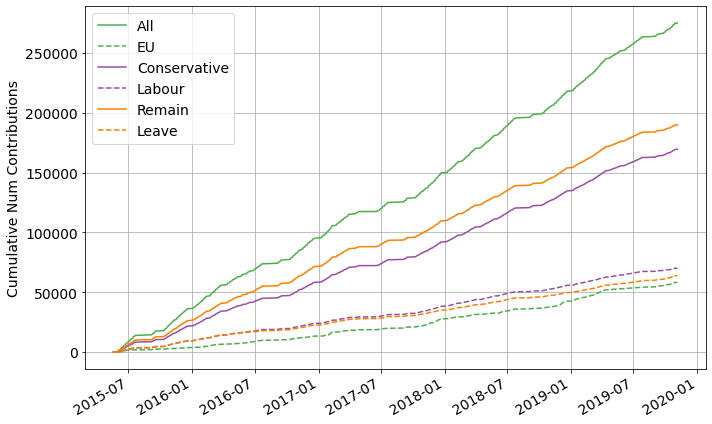

In [14]:
from cycler import cycler

fig, ax = plt.subplots(figsize=(10, 6))

colour_list = ["#e41a1c", "#377eb8", "#4daf4a", "#984ea3", "#ff7f00", "#ffff33"]

graph_cycler = (cycler(color=["#4daf4a", "#984ea3", "#ff7f00"]) *
                cycler(linestyle=['-', '--']))

ax.set_prop_cycle(graph_cycler)

gnames = ["All", "EU", "Conservative", "Labour", "Remain", "Leave"]

for i, contributions in enumerate([all_contributions, eu_mentions,
                                   all_contributions.query("party == 'Conservative'"), 
                                   all_contributions.query("party == 'Labour'"), 
                                   all_contributions.query("ref_stance == 'remain'"),
                                   all_contributions.query("ref_stance == 'leave'")]):
    cum_contributions = contributions.groupby("date").size().cumsum()
    cum_contributions.plot(ax=ax, label=gnames[i], grid=True)
    
ax.set_xlabel("")
ax.set_ylabel("Cumulative Num Contributions", fontsize=14)
plt.setp(ax.get_xticklabels(), fontsize=14)
plt.setp(ax.get_yticklabels(), fontsize=14)
ax.ticklabel_format(style='plain', axis='y')
plt.tight_layout()
ax.legend(fontsize=14)
    
plt.show()

# Produce the Graphs

The following code produces graphs for the meta analysis in the thesis.

In [15]:
def get_top_bottom_counts(df, percentile):
    quantile_value = df.quantile(percentile)
    
    top = df.loc[df > quantile_value]
    bottom = df.loc[df <= quantile_value]
    
    return quantile_value, top, bottom

def top_bottom_stats(df, percentile, stat_name=""):
    quantile_value, top, bottom = get_top_bottom_counts(df, percentile)
    
#     print("{0} in top {1}% - {2}".format(top.sum(), 100-percentile*100, stat_name))
#     print("{0} in bottom {1}% - {2}".format(bottom.sum(), percentile*100, stat_name))
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    sns.distplot(df[df <= quantile_value], hist=False, kde=True, ax=axes[0],
                 kde_kws={'linewidth': 2, 'shade': True})
    axes[0].set_title("Density Plot {0} for posts <= {1}%".format(stat_name, 100*percentile), fontsize=16)
    axes[0].set_xlabel(stat_name, fontsize=16)
    axes[0].set_ylabel("Density", fontsize=16)
    
    axes[0].xaxis.set_tick_params(labelsize=14, rotation=0)
    axes[0].yaxis.set_tick_params(labelsize=14)
    
    sns.distplot(df[df > quantile_value], hist=False, kde=True, ax=axes[1],
                 kde_kws={'linewidth': 2, 'shade': True})
    axes[1].set_title("Density Plot {0} for posts > {1}%".format(stat_name, 100*percentile), fontsize=16)
    axes[1].set_xlabel(stat_name, fontsize=16)
#     axes[1].set_ylabel("Density", fontsize=16)
    
    axes[1].xaxis.set_tick_params(labelsize=14, rotation=0)
    axes[1].yaxis.set_tick_params(labelsize=14)
    
    plt.tight_layout()
    
#     df[df <= quantile_value].plot.hist(grid=True, bins=30, rwidth=0.9, ax=axes[1,0])
#     axes[1,0].set_title("Density Plot {0} for posts <= {1}%".format(stat_name, 100*percentile))
#     axes[1,0].set_xlabel(stat_name)
    
#     df[df > quantile_value].plot.hist(grid=True, bins=30, rwidth=0.9, ax=axes[1,1])
#     axes[1,1].set_title("Density Plot {0} for posts > {1}%".format(stat_name, 100*percentile))
#     axes[1,1].set_xlabel(stat_name)
    
    return fig

## For All Contributions

First we produce all the graphs for All Contributions

### Words / Contribution

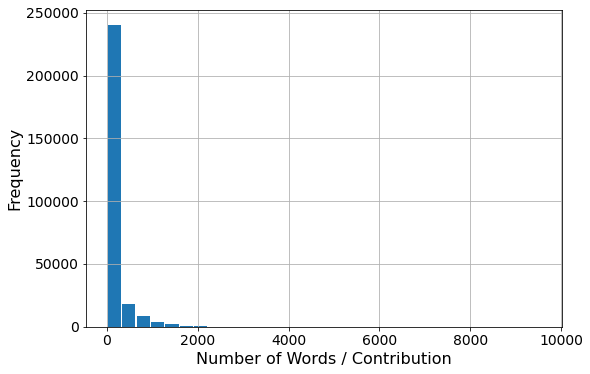

In [16]:
contrib_lengths = all_toks.apply(len)

fig, ax = plt.subplots(figsize=(8,5))
hist, bins, _ = ax.hist(contrib_lengths, bins=30, rwidth=0.9)

ax.xaxis.set_tick_params(labelsize=14, rotation=0)
ax.yaxis.set_tick_params(labelsize=14)

ax.set_xlabel("Number of Words / Contribution", fontsize=16)
ax.set_ylabel("Frequency", fontsize=16)
plt.tight_layout(pad=0)
ax.grid()

fig.savefig(os.path.join(out_dir, "All", "all_words_per_contribution_hist.pdf"))
plt.show()

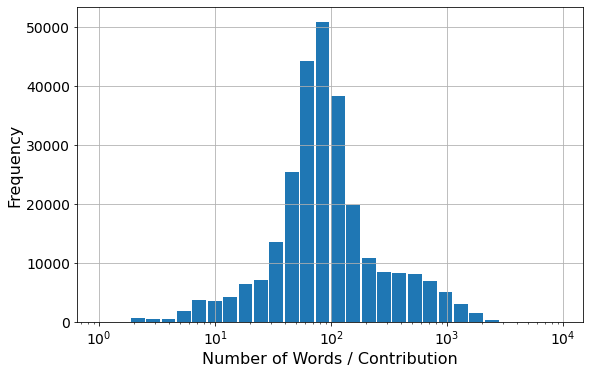

In [17]:
fig, ax = plt.subplots(figsize=(8,5))
logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
ax.hist(contrib_lengths, bins=logbins, rwidth=0.9)
plt.xscale('log')

ax.xaxis.set_tick_params(labelsize=14, rotation=0)
ax.yaxis.set_tick_params(labelsize=14)

ax.set_xlabel("Number of Words / Contribution", fontsize=16)
ax.set_ylabel("Frequency", fontsize=16)
plt.tight_layout(pad=0)
ax.grid()

fig.savefig(os.path.join(out_dir, "All", "all_words_per_contribution_log_hist.pdf"))
plt.show()

In [18]:
# logged_contrib_lengths = contrib_lengths.apply(np.log10)

# fig, ax = plt.subplots(figsize=(8,5))
# logged_contrib_lengths.plot.hist(grid=True, bins=30, rwidth=0.9, ax=ax)
# plt.xticks([0,1,2,3,4])
# ax.set_xticklabels([10**x for x in ax.get_xticks()])
# fig.savefig(os.path.join(out_dir, "All", "all_words_per_contribution_log_hist.pdf"))
# plt.show()

### Words / MP

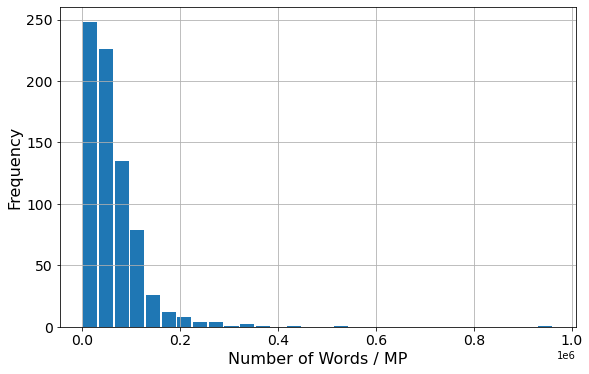

In [19]:
words_per_user = contrib_lengths.groupby(all_contributions["PimsId"]).sum()

fig, ax = plt.subplots(figsize=(8,5))
hist, bins, _ = ax.hist(words_per_user, bins=30, rwidth=0.9)

ax.xaxis.set_tick_params(labelsize=14, rotation=0)
ax.yaxis.set_tick_params(labelsize=14)

ax.set_xlabel("Number of Words / MP", fontsize=16)
ax.set_ylabel("Frequency", fontsize=16)
plt.tight_layout(pad=0)
ax.grid()

fig.savefig(os.path.join(out_dir, "All", "all_words_per_mp_hist.pdf"))
plt.show()

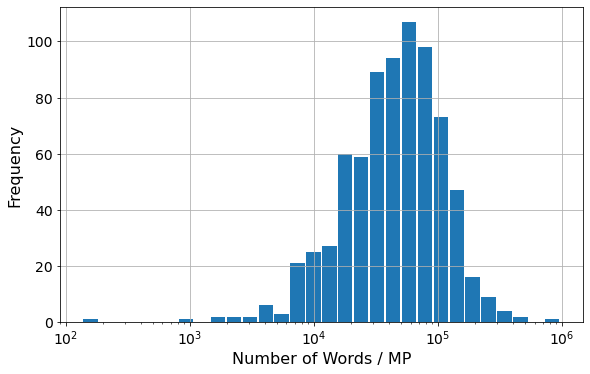

In [20]:
fig, ax = plt.subplots(figsize=(8,5))
logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
ax.hist(words_per_user, bins=logbins, rwidth=0.9)
plt.xscale('log')

ax.xaxis.set_tick_params(labelsize=14, rotation=0)
ax.yaxis.set_tick_params(labelsize=14)

ax.set_xlabel("Number of Words / MP", fontsize=16)
ax.set_ylabel("Frequency", fontsize=16)
plt.tight_layout(pad=0)
ax.grid()

fig.savefig(os.path.join(out_dir, "All", "all_words_per_mp_log_hist.pdf"))
plt.show()

### Contributions / MP

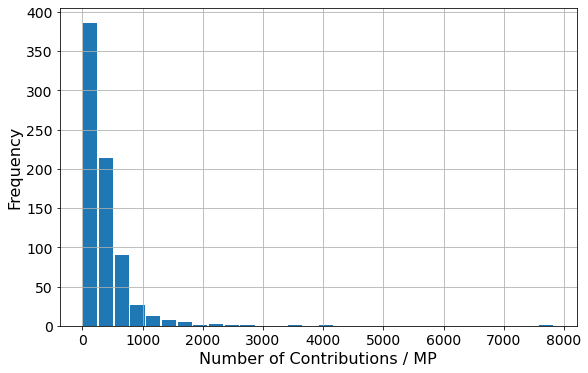

In [21]:
contribs_per_user = all_contributions.groupby("PimsId").size()

fig, ax = plt.subplots(figsize=(8,5))
hist, bins, _ = ax.hist(contribs_per_user, bins=30, rwidth=0.9)

ax.xaxis.set_tick_params(labelsize=14, rotation=0)
ax.yaxis.set_tick_params(labelsize=14)

ax.set_xlabel("Number of Contributions / MP", fontsize=16)
ax.set_ylabel("Frequency", fontsize=16)
plt.tight_layout(pad=0)
ax.grid()

fig.savefig(os.path.join(out_dir, "All", "all_contributions_per_mp_hist.pdf"))
plt.show()

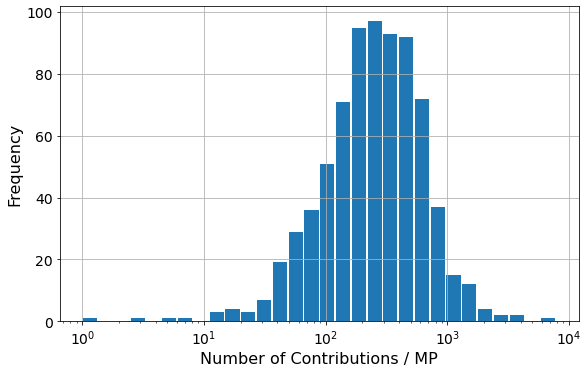

In [22]:
fig, ax = plt.subplots(figsize=(8,5))
logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
ax.hist(contribs_per_user, bins=logbins, rwidth=0.9)
plt.xscale('log')

ax.xaxis.set_tick_params(labelsize=14, rotation=0)
ax.yaxis.set_tick_params(labelsize=14)

ax.set_xlabel("Number of Contributions / MP", fontsize=16)
ax.set_ylabel("Frequency", fontsize=16)
plt.tight_layout(pad=0)
ax.grid()

fig.savefig(os.path.join(out_dir, "All", "all_contributions_per_mp_log_hist.pdf"))
plt.show()

### Words / Contribution Above and Below 75th Percentile

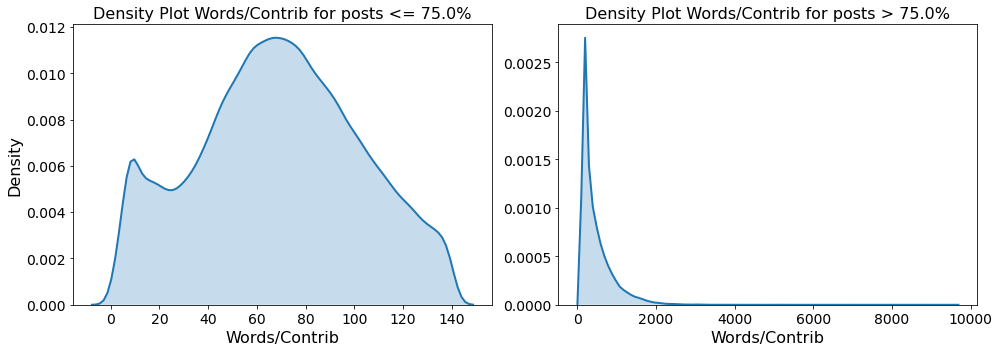

In [23]:
fig = top_bottom_stats(contrib_lengths, 0.75, "Words/Contrib")
fig.savefig(os.path.join(out_dir, "All", "words_per_contrib_75th_percentile.pdf"))
plt.show()

### Contributions / MP Above and Below 75th Percentile

In [24]:
quantile_value = contribs_per_user.quantile(0.75)
    
print("Number of users in top 25%:\t", contribs_per_user.loc[contribs_per_user > quantile_value].shape[0])
print("Number of users in bottom 75%:\t", contribs_per_user.loc[contribs_per_user <= quantile_value].shape[0])

Number of users in top 25%:	 186
Number of users in bottom 75%:	 563


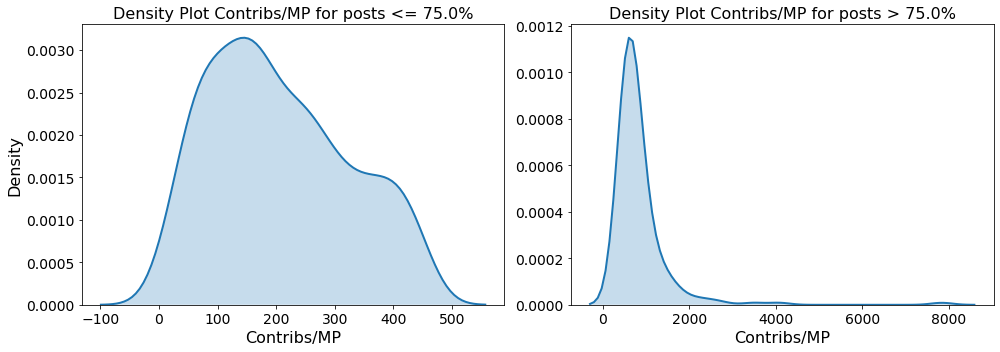

In [25]:
fig = top_bottom_stats(contribs_per_user, 0.75, "Contribs/MP")
fig.savefig(os.path.join(out_dir, "All", "contribs_per_mp_75th_percentile.pdf"))
plt.show()

## For EU Contributions

Now we repeat all the above graphs but for EU contributions.

### Words / Contribution

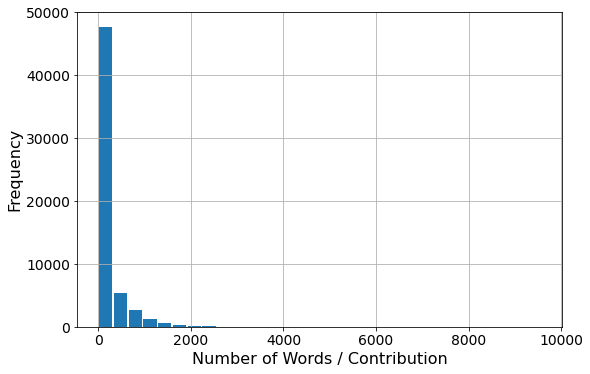

In [26]:
contrib_lengths = eu_toks.apply(len)

fig, ax = plt.subplots(figsize=(8,5))
hist, bins, _ = ax.hist(contrib_lengths, bins=30, rwidth=0.9)

ax.xaxis.set_tick_params(labelsize=14, rotation=0)
ax.yaxis.set_tick_params(labelsize=14)

ax.set_xlabel("Number of Words / Contribution", fontsize=16)
ax.set_ylabel("Frequency", fontsize=16)
plt.tight_layout(pad=0)
ax.grid()

fig.savefig(os.path.join(out_dir, "EU", "eu_words_per_contribution_hist.pdf"))
plt.show()

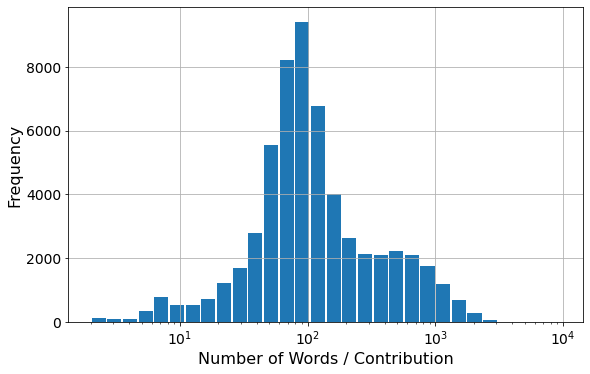

In [27]:
fig, ax = plt.subplots(figsize=(8,5))
logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
ax.hist(contrib_lengths, bins=logbins, rwidth=0.9)
plt.xscale('log')

ax.xaxis.set_tick_params(labelsize=14, rotation=0)
ax.yaxis.set_tick_params(labelsize=14)

ax.set_xlabel("Number of Words / Contribution", fontsize=16)
ax.set_ylabel("Frequency", fontsize=16)
plt.tight_layout(pad=0)
ax.grid()

fig.savefig(os.path.join(out_dir, "EU", "eu_words_per_contribution_log_hist.pdf"))
plt.show()

### Words / MP

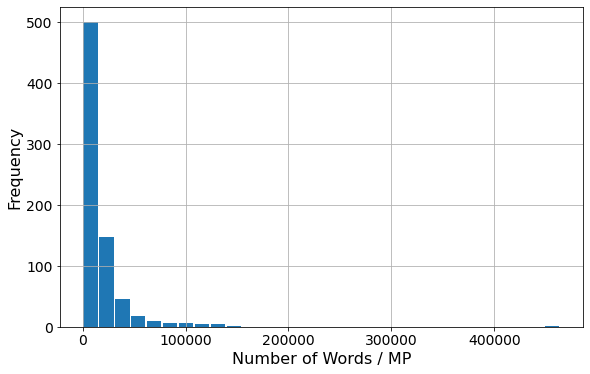

In [28]:
words_per_user = contrib_lengths.groupby(eu_mentions["PimsId"]).sum()

fig, ax = plt.subplots(figsize=(8,5))
hist, bins, _ = ax.hist(words_per_user, bins=30, rwidth=0.9)

ax.xaxis.set_tick_params(labelsize=14, rotation=0)
ax.yaxis.set_tick_params(labelsize=14)

ax.set_xlabel("Number of Words / MP", fontsize=16)
ax.set_ylabel("Frequency", fontsize=16)
plt.tight_layout(pad=0)
ax.grid()

fig.savefig(os.path.join(out_dir, "EU", "eu_words_per_mp_hist.pdf"))
plt.show()

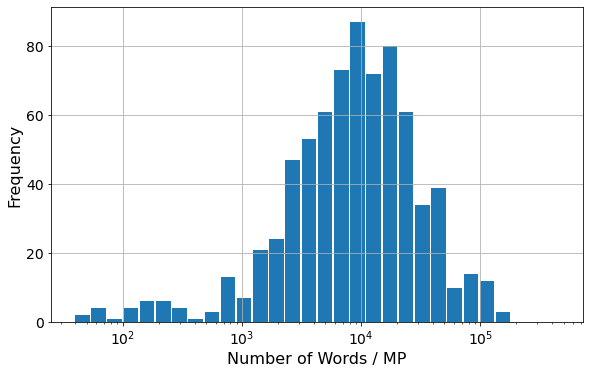

In [29]:
fig, ax = plt.subplots(figsize=(8,5))
logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
ax.hist(words_per_user, bins=logbins, rwidth=0.9)
plt.xscale('log')

ax.xaxis.set_tick_params(labelsize=14, rotation=0)
ax.yaxis.set_tick_params(labelsize=14)

ax.set_xlabel("Number of Words / MP", fontsize=16)
ax.set_ylabel("Frequency", fontsize=16)
plt.tight_layout(pad=0)
ax.grid()

fig.savefig(os.path.join(out_dir, "EU", "eu_words_per_mp_log_hist.pdf"))
plt.show()

### Contributions / MP

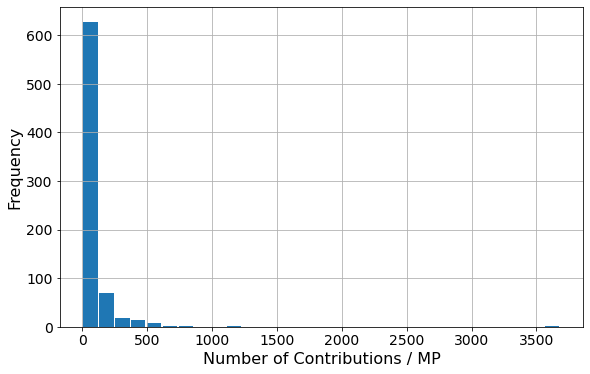

In [30]:
contribs_per_user = eu_mentions.groupby("PimsId").size()

fig, ax = plt.subplots(figsize=(8,5))
hist, bins, _ = ax.hist(contribs_per_user, bins=30, rwidth=0.9)

ax.xaxis.set_tick_params(labelsize=14, rotation=0)
ax.yaxis.set_tick_params(labelsize=14)

ax.set_xlabel("Number of Contributions / MP", fontsize=16)
ax.set_ylabel("Frequency", fontsize=16)
plt.tight_layout(pad=0)
ax.grid()

fig.savefig(os.path.join(out_dir, "EU", "eu_contributions_per_mp_hist.pdf"))
plt.show()

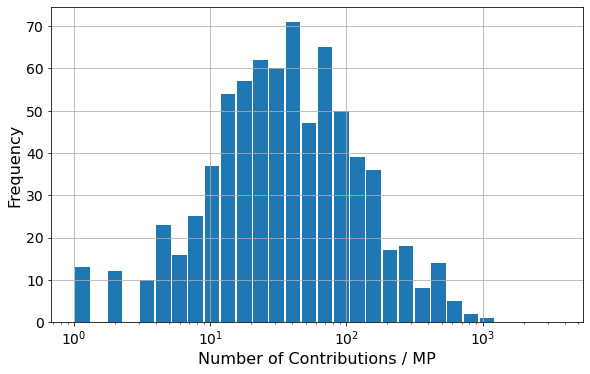

In [31]:
fig, ax = plt.subplots(figsize=(8,5))
logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
ax.hist(contribs_per_user, bins=logbins, rwidth=0.9)
plt.xscale('log')

ax.xaxis.set_tick_params(labelsize=14, rotation=0)
ax.yaxis.set_tick_params(labelsize=14)

ax.set_xlabel("Number of Contributions / MP", fontsize=16)
ax.set_ylabel("Frequency", fontsize=16)
plt.tight_layout(pad=0)
ax.grid()

fig.savefig(os.path.join(out_dir, "EU", "eu_contributions_per_mp_log_hist.pdf"))
plt.show()

### Words / Contribution Above and Below 75th Percentile

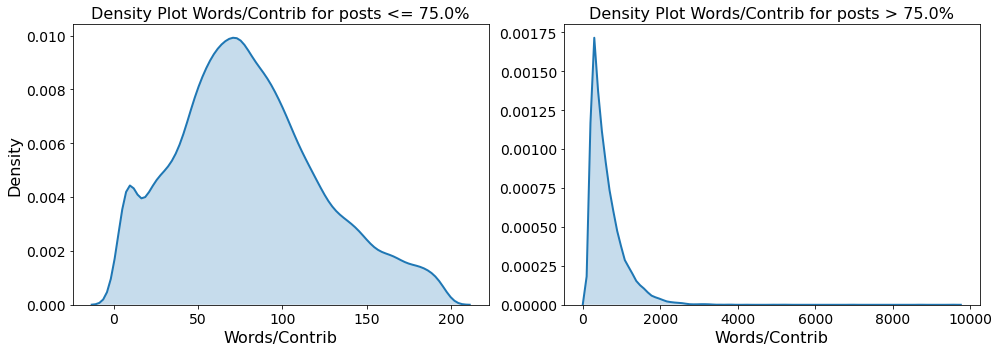

In [32]:
fig = top_bottom_stats(contrib_lengths, 0.75, "Words/Contrib")
fig.savefig(os.path.join(out_dir, "EU", "eu_words_per_contrib_75th_percentile.pdf"))
plt.show()

### Contributions / MP Above and Below 75th Percentile

In [33]:
quantile_value = contribs_per_user.quantile(0.75)
    
print("Number of users in top 25%:\t", contribs_per_user.loc[contribs_per_user > quantile_value].shape[0])
print("Number of users in bottom 75%:\t", contribs_per_user.loc[contribs_per_user <= quantile_value].shape[0])

Number of users in top 25%:	 186
Number of users in bottom 75%:	 557


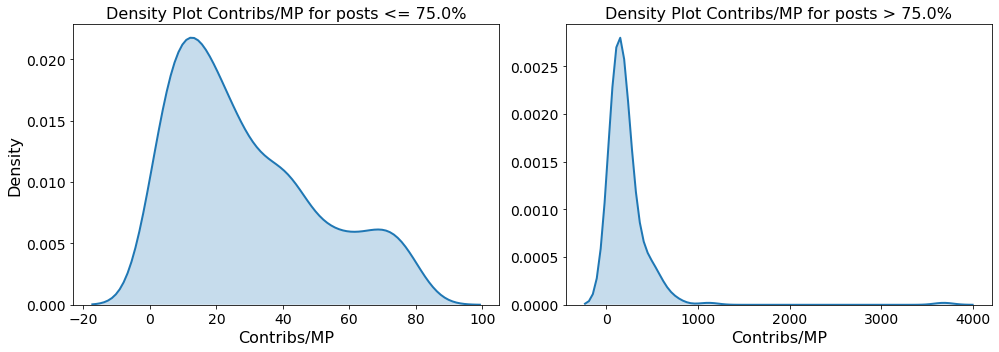

In [34]:
fig = top_bottom_stats(contribs_per_user, 0.75, "Contribs/MP")
fig.savefig(os.path.join(out_dir, "EU", "eu_contribs_per_mp_75th_percentile.pdf"))
plt.show()